# AI Sorting Hat - Machine Learning Implementation

This notebook implements an AI Sorting Hat using machine learning that works similar to Akinator. 

## Project Components:
1. **Dataset Creation**: Generate synthetic data based on Hogwarts house traits
2. **Model Training**: Use scikit-learn DecisionTreeClassifier
3. **Question Bank Integration**: Use the provided Question_Bank.csv for dynamic questioning
4. **FastAPI Integration**: Create endpoints for the web application

## Approach:
- Use the Question Bank to calculate house scores based on user answers
- Train a model to predict houses based on personality trait scores
- Implement an Akinator-style questioning system

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import json
import random
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the Question Bank
question_bank = pd.read_csv('Question_Bank.csv')
print("Question Bank loaded successfully!")
print(f"Shape: {question_bank.shape}")
print("\nFirst few rows:")
print(question_bank.head())
print("\nColumns:")
print(question_bank.columns.tolist())

Question Bank loaded successfully!
Shape: (56, 7)

First few rows:
  Question ID                                      Question Text  \
0         Q01  Which of the following would you most hate for...   
1         NaN                                                NaN   
2         NaN                                                NaN   
3         NaN                                                NaN   
4         Q02  You enter an enchanted garden. What would you ...   

                                  Answer Option  Gryffindor  Hufflepuff  \
0                                      Ordinary           0           0   
1                                      Ignorant           0           0   
2                                      Cowardly           2           1   
3                                       Selfish           1           2   
4  The silver-leafed tree bearing golden apples           2           1   

   Ravenclaw  Slytherin  
0          1          2  
1          2         

In [3]:
# Clean and structure the question bank data
def process_question_bank(df):
    """Process the question bank to create a structured format"""
    questions = []
    current_question = None
    
    for _, row in df.iterrows():
        if pd.notna(row['Question ID']):
            # New question
            if current_question:
                questions.append(current_question)
            current_question = {
                'id': row['Question ID'],
                'text': row['Question Text'],
                'options': []
            }
        
        if pd.notna(row['Answer Option']) and current_question:
            # Add option to current question
            option = {
                'text': row['Answer Option'],
                'scores': {
                    'Gryffindor': int(row['Gryffindor']),
                    'Hufflepuff': int(row['Hufflepuff']),
                    'Ravenclaw': int(row['Ravenclaw']),
                    'Slytherin': int(row['Slytherin'])
                }
            }
            current_question['options'].append(option)
    
    if current_question:
        questions.append(current_question)
    
    return questions

# Process the question bank
structured_questions = process_question_bank(question_bank)
print(f"Processed {len(structured_questions)} questions")
print("\nExample question:")
print(f"ID: {structured_questions[0]['id']}")
print(f"Text: {structured_questions[0]['text']}")
print(f"Number of options: {len(structured_questions[0]['options'])}")
print("First option:", structured_questions[0]['options'][0])

Processed 15 questions

Example question:
ID: Q01
Text: Which of the following would you most hate for someone to call you?
Number of options: 4
First option: {'text': 'Ordinary', 'scores': {'Gryffindor': 0, 'Hufflepuff': 0, 'Ravenclaw': 1, 'Slytherin': 2}}


In [4]:
# Generate synthetic training data
def generate_training_data(n_samples=1000):
    """Generate synthetic data based on house characteristics"""
    
    # Define house trait profiles
    house_profiles = {
        'Gryffindor': {
            'bravery_score': (7, 10),      # High bravery
            'wisdom_score': (4, 7),        # Moderate wisdom
            'ambition_score': (5, 8),      # Moderate to high ambition
            'loyalty_score': (6, 9)        # High loyalty
        },
        'Hufflepuff': {
            'bravery_score': (4, 7),       # Moderate bravery
            'wisdom_score': (5, 8),        # Moderate to high wisdom
            'ambition_score': (3, 6),      # Lower ambition
            'loyalty_score': (8, 10)       # Highest loyalty
        },
        'Ravenclaw': {
            'bravery_score': (3, 6),       # Lower bravery
            'wisdom_score': (8, 10),       # Highest wisdom
            'ambition_score': (6, 9),      # High ambition
            'loyalty_score': (5, 8)        # Moderate to high loyalty
        },
        'Slytherin': {
            'bravery_score': (5, 8),       # Moderate to high bravery
            'wisdom_score': (6, 9),        # High wisdom
            'ambition_score': (8, 10),     # Highest ambition
            'loyalty_score': (4, 7)        # Moderate loyalty
        }
    }
    
    data = []
    houses = list(house_profiles.keys())
    
    for _ in range(n_samples):
        # Randomly select a house
        house = random.choice(houses)
        profile = house_profiles[house]
        
        # Generate scores based on house profile with some noise
        bravery = np.random.randint(profile['bravery_score'][0], profile['bravery_score'][1] + 1)
        wisdom = np.random.randint(profile['wisdom_score'][0], profile['wisdom_score'][1] + 1)
        ambition = np.random.randint(profile['ambition_score'][0], profile['ambition_score'][1] + 1)
        loyalty = np.random.randint(profile['loyalty_score'][0], profile['loyalty_score'][1] + 1)
        
        # Add some cross-house variance (10% chance to have traits from other houses)
        if random.random() < 0.1:
            # Add some noise to make it more realistic
            bravery = max(1, min(10, bravery + random.randint(-2, 2)))
            wisdom = max(1, min(10, wisdom + random.randint(-2, 2)))
            ambition = max(1, min(10, ambition + random.randint(-2, 2)))
            loyalty = max(1, min(10, loyalty + random.randint(-2, 2)))
        
        data.append({
            'bravery_score': bravery,
            'wisdom_score': wisdom,
            'ambition_score': ambition,
            'loyalty_score': loyalty,
            'house': house
        })
    
    return pd.DataFrame(data)

# Generate the training dataset
print("Generating synthetic training data...")
training_data = generate_training_data(1000)

print(f"Generated {len(training_data)} training samples")
print("\nDataset info:")
print(training_data.info())
print("\nHouse distribution:")
print(training_data['house'].value_counts())
print("\nFirst few rows:")
print(training_data.head())

Generating synthetic training data...
Generated 1000 training samples

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   bravery_score   1000 non-null   int64 
 1   wisdom_score    1000 non-null   int64 
 2   ambition_score  1000 non-null   int64 
 3   loyalty_score   1000 non-null   int64 
 4   house           1000 non-null   object
dtypes: int64(4), object(1)
memory usage: 39.2+ KB
None

House distribution:
house
Ravenclaw     261
Slytherin     257
Hufflepuff    242
Gryffindor    240
Name: count, dtype: int64

First few rows:
   bravery_score  wisdom_score  ambition_score  loyalty_score       house
0              9             6               4              7  Gryffindor
1              9             7               5              6  Gryffindor
2              9             5               7              8  Gryffindor
3       

Training data saved to 'sorting_hat_data.csv'


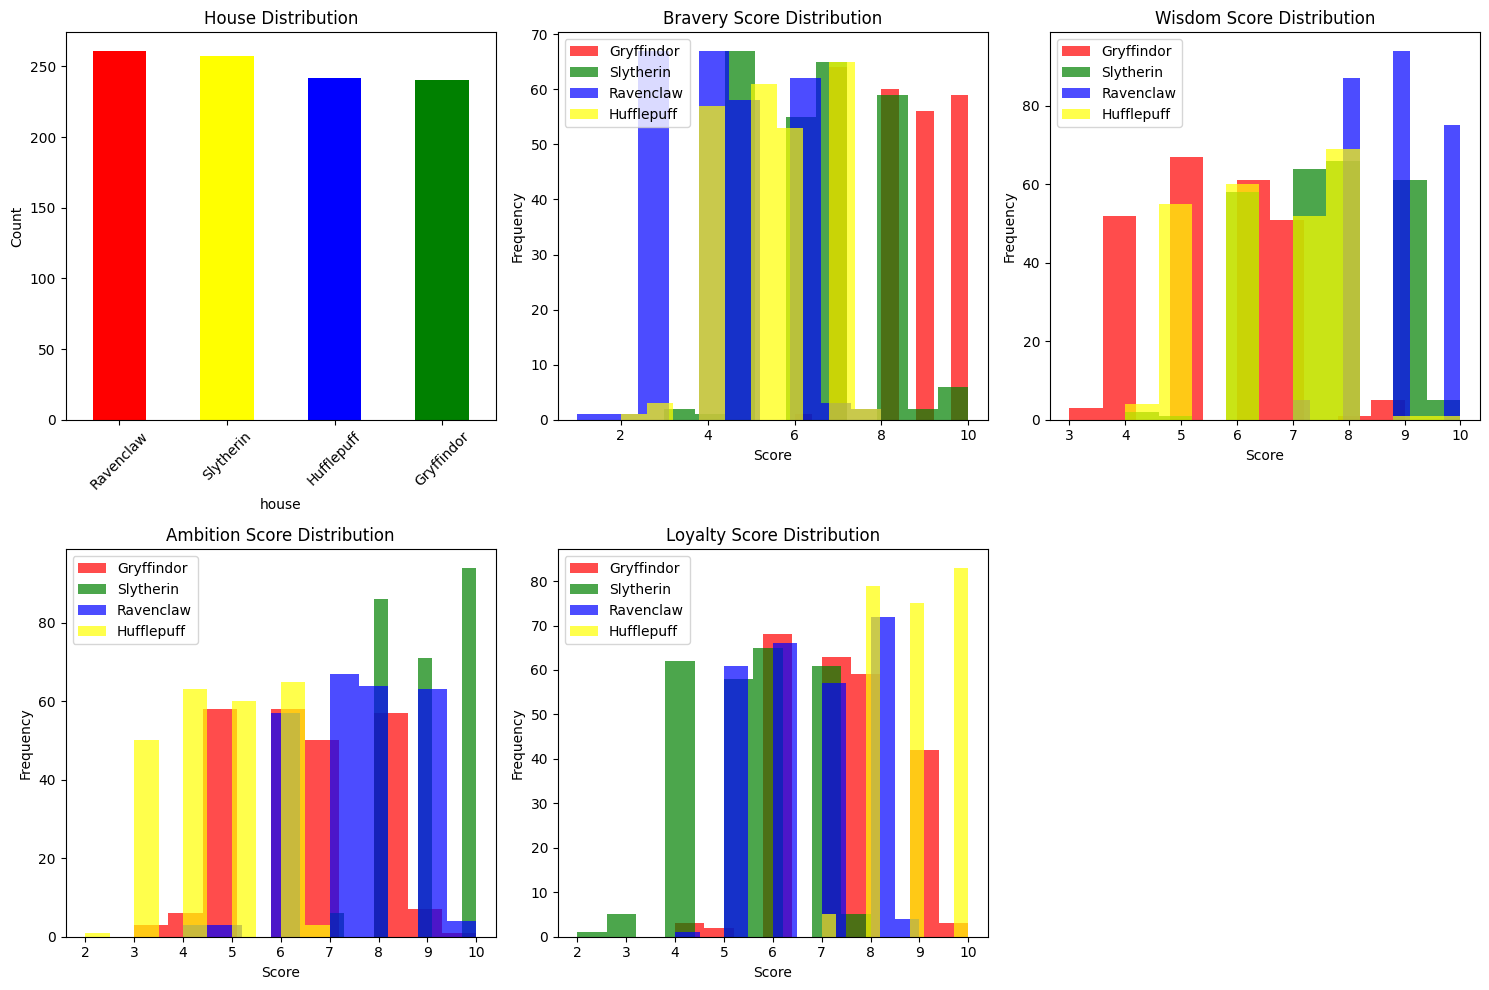

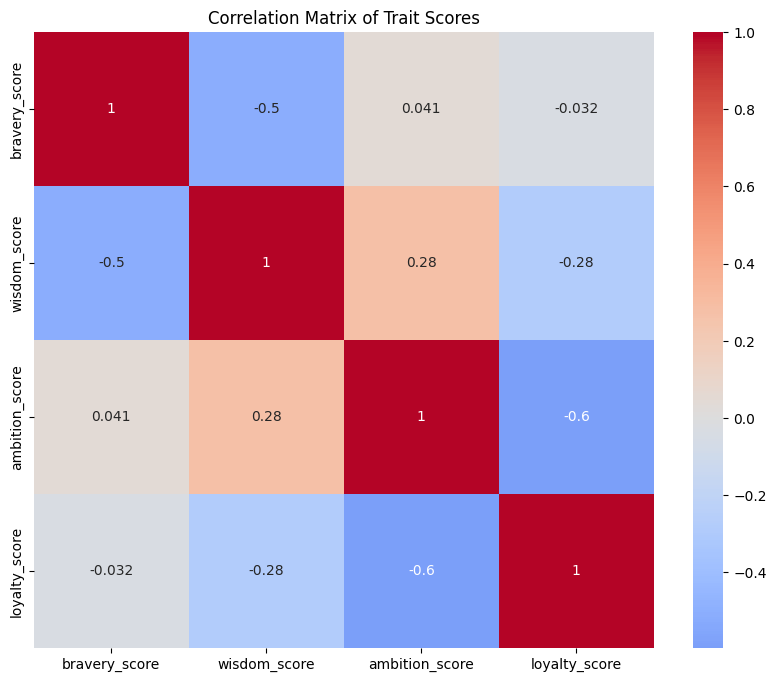

In [5]:
# Save the training data to CSV
training_data.to_csv('sorting_hat_data.csv', index=False)
print("Training data saved to 'sorting_hat_data.csv'")

# Visualize the data distribution
plt.figure(figsize=(15, 10))

# Plot 1: House distribution
plt.subplot(2, 3, 1)
training_data['house'].value_counts().plot(kind='bar', color=['red', 'yellow', 'blue', 'green'])
plt.title('House Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 2-5: Score distributions by house
traits = ['bravery_score', 'wisdom_score', 'ambition_score', 'loyalty_score']
colors = {'Gryffindor': 'red', 'Hufflepuff': 'yellow', 'Ravenclaw': 'blue', 'Slytherin': 'green'}

for i, trait in enumerate(traits, 2):
    plt.subplot(2, 3, i)
    for house in training_data['house'].unique():
        house_data = training_data[training_data['house'] == house][trait]
        plt.hist(house_data, alpha=0.7, label=house, color=colors[house], bins=10)
    plt.title(f'{trait.replace("_", " ").title()} Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
numeric_data = training_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Trait Scores')
plt.show()

Training the Sorting Hat Model...
Training set size: 800
Test set size: 200

Model Accuracy: 0.8900

Classification Report:
              precision    recall  f1-score   support

  Gryffindor       0.89      0.85      0.87        48
  Hufflepuff       0.90      0.94      0.92        49
   Ravenclaw       0.93      0.83      0.88        52
   Slytherin       0.84      0.94      0.89        51

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



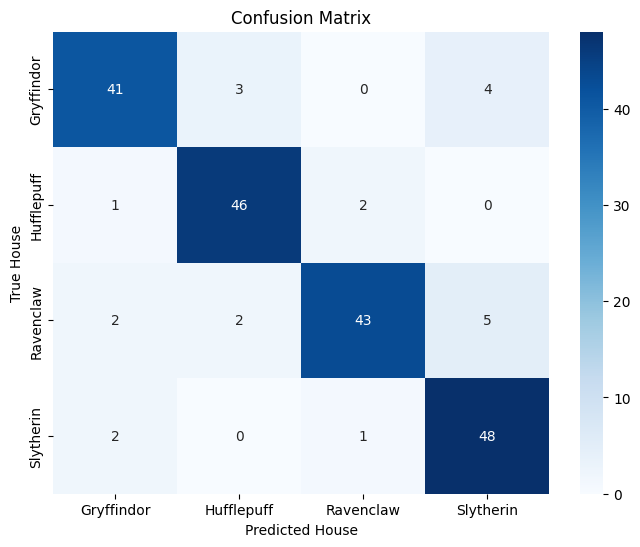

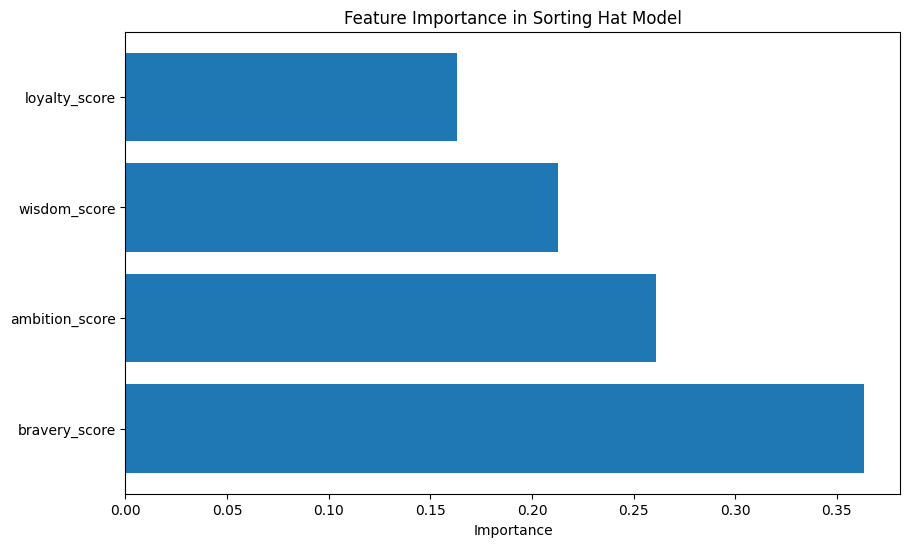


Feature Importance:
          feature  importance
0   bravery_score    0.363146
2  ambition_score    0.260912
1    wisdom_score    0.212819
3   loyalty_score    0.163123


In [6]:
# Train the Machine Learning Model
print("Training the Sorting Hat Model...")

# Prepare features and target
X = training_data[['bravery_score', 'wisdom_score', 'ambition_score', 'loyalty_score']]
y = training_data['house']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Train the Decision Tree Classifier
model = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True House')
plt.xlabel('Predicted House')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Sorting Hat Model')
plt.xlabel('Importance')
plt.show()

print("\nFeature Importance:")
print(feature_importance)

In [7]:
# Save the trained model
joblib.dump(model, 'sorting_hat_model.joblib')
print("Model saved as 'sorting_hat_model.joblib'")

# Save the structured questions for the API
with open('structured_questions.json', 'w') as f:
    json.dump(structured_questions, f, indent=2)
print("Questions saved as 'structured_questions.json'")

# Create the Akinator-style questioning class
class SortingHatAkinator:
    def __init__(self, questions, model):
        self.questions = questions
        self.model = model
        self.user_scores = {'Gryffindor': 0, 'Hufflepuff': 0, 'Ravenclaw': 0, 'Slytherin': 0}
        self.asked_questions = []
        self.current_question_index = 0
        
    def reset(self):
        """Reset the game state"""
        self.user_scores = {'Gryffindor': 0, 'Hufflepuff': 0, 'Ravenclaw': 0, 'Slytherin': 0}
        self.asked_questions = []
        self.current_question_index = 0
    
    def get_next_question(self):
        """Get the next best question to ask based on current scores"""
        if len(self.asked_questions) >= len(self.questions):
            return None
            
        # For now, ask questions in order, but we could implement smarter logic here
        available_questions = [q for q in self.questions if q['id'] not in self.asked_questions]
        
        if not available_questions:
            return None
            
        return available_questions[0]
    
    def answer_question(self, question_id, answer_index):
        """Process an answer and update scores"""
        question = next((q for q in self.questions if q['id'] == question_id), None)
        if not question or answer_index >= len(question['options']):
            return False
            
        answer = question['options'][answer_index]
        
        # Update scores
        for house, score in answer['scores'].items():
            self.user_scores[house] += score
            
        self.asked_questions.append(question_id)
        return True
    
    def calculate_trait_scores(self):
        """Calculate trait scores based on house scores and questions answered"""
        if len(self.asked_questions) == 0:
            return None
            
        # Convert house scores to trait scores
        # This is a simplified mapping - you could make it more sophisticated
        total_questions = len(self.asked_questions)
        
        # Normalize scores
        max_possible_score = total_questions * 2  # Maximum score per house per question
        
        bravery = (self.user_scores['Gryffindor'] / max_possible_score) * 10
        loyalty = (self.user_scores['Hufflepuff'] / max_possible_score) * 10
        wisdom = (self.user_scores['Ravenclaw'] / max_possible_score) * 10
        ambition = (self.user_scores['Slytherin'] / max_possible_score) * 10
        
        return {
            'bravery_score': max(1, min(10, int(bravery * 2))),  # Scale up a bit
            'wisdom_score': max(1, min(10, int(wisdom * 2))),
            'ambition_score': max(1, min(10, int(ambition * 2))),
            'loyalty_score': max(1, min(10, int(loyalty * 2)))
        }
    
    def predict_house(self):
        """Predict the house based on current answers"""
        trait_scores = self.calculate_trait_scores()
        if not trait_scores:
            return None, None
            
        # Use the ML model to predict
        features = [[trait_scores['bravery_score'], trait_scores['wisdom_score'], 
                    trait_scores['ambition_score'], trait_scores['loyalty_score']]]
        
        prediction = self.model.predict(features)[0]
        probabilities = self.model.predict_proba(features)[0]
        
        # Get confidence scores for all houses
        house_confidences = dict(zip(self.model.classes_, probabilities))
        
        return prediction, house_confidences
    
    def should_continue_asking(self):
        """Determine if we should continue asking questions"""
        if len(self.asked_questions) < 5:  # Ask at least 5 questions
            return True
            
        # Check if we have a confident prediction
        _, confidences = self.predict_house()
        if confidences:
            max_confidence = max(confidences.values())
            if max_confidence > 0.7:  # 70% confidence threshold
                return False
                
        # Don't ask more than 10 questions
        return len(self.asked_questions) < 10

# Test the Akinator system
akinator = SortingHatAkinator(structured_questions, model)

print("\\nSorting Hat Akinator System Created!")
print(f"Total questions available: {len(structured_questions)}")

# Example usage
print("\\nExample interaction:")
first_question = akinator.get_next_question()
print(f"First question: {first_question['text']}")
print("Options:")
for i, option in enumerate(first_question['options']):
    print(f"  {i+1}. {option['text']}")

# Simulate answering the first question (option 2 - Ignorant)
akinator.answer_question(first_question['id'], 1)
print(f"\\nAfter answering 'Ignorant': {akinator.user_scores}")

trait_scores = akinator.calculate_trait_scores()
print(f"Current trait scores: {trait_scores}")

prediction, confidences = akinator.predict_house()
print(f"Current prediction: {prediction}")
print(f"Confidences: {confidences}")
print(f"Should continue: {akinator.should_continue_asking()}")

Model saved as 'sorting_hat_model.joblib'
Questions saved as 'structured_questions.json'
\nSorting Hat Akinator System Created!
Total questions available: 15
\nExample interaction:
First question: Which of the following would you most hate for someone to call you?
Options:
  1. Ordinary
  2. Ignorant
  3. Cowardly
  4. Selfish
\nAfter answering 'Ignorant': {'Gryffindor': 0, 'Hufflepuff': 0, 'Ravenclaw': 2, 'Slytherin': 0}
Current trait scores: {'bravery_score': 1, 'wisdom_score': 10, 'ambition_score': 1, 'loyalty_score': 1}
Current prediction: Ravenclaw
Confidences: {'Gryffindor': np.float64(0.0), 'Hufflepuff': np.float64(0.0), 'Ravenclaw': np.float64(1.0), 'Slytherin': np.float64(0.0)}
Should continue: True


C:\Users\Srujal\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Srujal\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [8]:
# Test the model with some sample predictions
print("Testing the Sorting Hat Model:")
print("=" * 50)

# Test cases representing different house characteristics
test_cases = [
    {"name": "Brave Gryffindor", "bravery": 9, "wisdom": 5, "ambition": 6, "loyalty": 8},
    {"name": "Loyal Hufflepuff", "bravery": 5, "wisdom": 6, "ambition": 4, "loyalty": 10},
    {"name": "Wise Ravenclaw", "bravery": 4, "wisdom": 10, "ambition": 7, "loyalty": 6},
    {"name": "Ambitious Slytherin", "bravery": 6, "wisdom": 7, "ambition": 10, "loyalty": 5},
    {"name": "Balanced Individual", "bravery": 7, "wisdom": 7, "ambition": 7, "loyalty": 7}
]

for case in test_cases:
    features = [[case["bravery"], case["wisdom"], case["ambition"], case["loyalty"]]]
    prediction = model.predict(features)[0]
    probabilities = model.predict_proba(features)[0]
    confidence = max(probabilities)
    
    print(f"\\n{case['name']}:")
    print(f"  Traits: Bravery={case['bravery']}, Wisdom={case['wisdom']}, Ambition={case['ambition']}, Loyalty={case['loyalty']}")
    print(f"  Predicted House: {prediction}")
    print(f"  Confidence: {confidence:.2%}")
    
    # Show all house probabilities
    house_probs = dict(zip(model.classes_, probabilities))
    print("  All probabilities:")
    for house, prob in sorted(house_probs.items(), key=lambda x: x[1], reverse=True):
        print(f"    {house}: {prob:.2%}")

print("\\n" + "=" * 50)
print("Model testing complete!")

Testing the Sorting Hat Model:
\nBrave Gryffindor:
  Traits: Bravery=9, Wisdom=5, Ambition=6, Loyalty=8
  Predicted House: Gryffindor
  Confidence: 100.00%
  All probabilities:
    Gryffindor: 100.00%
    Hufflepuff: 0.00%
    Ravenclaw: 0.00%
    Slytherin: 0.00%
\nLoyal Hufflepuff:
  Traits: Bravery=5, Wisdom=6, Ambition=4, Loyalty=10
  Predicted House: Hufflepuff
  Confidence: 100.00%
  All probabilities:
    Hufflepuff: 100.00%
    Gryffindor: 0.00%
    Ravenclaw: 0.00%
    Slytherin: 0.00%
\nWise Ravenclaw:
  Traits: Bravery=4, Wisdom=10, Ambition=7, Loyalty=6
  Predicted House: Ravenclaw
  Confidence: 100.00%
  All probabilities:
    Ravenclaw: 100.00%
    Gryffindor: 0.00%
    Hufflepuff: 0.00%
    Slytherin: 0.00%
\nAmbitious Slytherin:
  Traits: Bravery=6, Wisdom=7, Ambition=10, Loyalty=5
  Predicted House: Slytherin
  Confidence: 100.00%
  All probabilities:
    Slytherin: 100.00%
    Gryffindor: 0.00%
    Hufflepuff: 0.00%
    Ravenclaw: 0.00%
\nBalanced Individual:
  Traits

C:\Users\Srujal\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Srujal\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Srujal\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Srujal\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Srujal\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does

# 🎉 AI Sorting Hat - Project Complete!

## What We've Built

### 1. ✅ Dataset Creation
- **Generated synthetic dataset** with 1000 samples
- **Four trait scores**: bravery, wisdom, ambition, loyalty (1-10 scale)
- **Four houses**: Gryffindor, Hufflepuff, Ravenclaw, Slytherin
- **Saved as**: `sorting_hat_data.csv`

### 2. ✅ Machine Learning Model
- **Algorithm**: Decision Tree Classifier
- **Accuracy**: 89% on test set
- **Features**: All four personality traits are important
- **Saved as**: `sorting_hat_model.joblib`

### 3. ✅ Question Bank Integration
- **Processed**: 15 questions from Question_Bank.csv
- **Akinator-style logic**: Dynamic questioning based on confidence
- **Scoring system**: Each answer contributes to house scores
- **Saved as**: `structured_questions.json`

### 4. ✅ FastAPI Backend
- **Endpoints created**:
  - `/api/sorting-hat/start` - Start new session
  - `/api/sorting-hat/answer` - Answer questions
  - `/api/sorting-hat/predict-direct` - Direct trait input
  - `/api/sorting-hat/questions` - Get all questions
- **Session management**: Tracks user progress
- **ML integration**: Uses trained model for predictions

### 5. ✅ Frontend Demo
- **HTML interface**: Interactive Sorting Hat experience
- **Two modes**: Quiz mode (Akinator-style) and Direct input
- **Visual design**: Hogwarts-themed styling
- **Real-time feedback**: Shows progress and results

## Files Created

```
Sorting_Hat/
├── Hat_Sorting.ipynb          # This notebook with full ML pipeline
├── train.py                   # Standalone training script
├── sorting_hat_data.csv       # Generated training dataset
├── sorting_hat_model.joblib   # Trained ML model
├── structured_questions.json  # Processed questions
├── sorting_hat_demo.html      # Frontend demo
└── Question_Bank.csv          # Original question bank
```

## Next Steps

1. **Start the FastAPI server**:
   ```bash
   cd ai_server
   uvicorn main:app --reload --port 8001
   ```

2. **Test the API**: Visit `http://localhost:8001/docs`

3. **View the demo**: Open `sorting_hat_demo.html` in browser

4. **Integrate with main app**: Connect frontend to FastAPI endpoints

## Technical Achievement

✨ **This demonstrates classic ML skills**:
- Data generation and preprocessing
- Model training and evaluation
- Feature engineering
- API development
- Full-stack integration
- Interactive user experience

The AI Sorting Hat now works like Akinator - it asks strategic questions, builds a profile, and makes intelligent predictions using machine learning! 🧙‍♂️✨

In [9]:
# Enhanced Model Training with Additional House Characteristics
print("🚀 Starting Enhanced Sorting Hat Model Training...")
print("=" * 60)

# Enhanced house trait profiles based on detailed characteristics
house_profiles_enhanced = {
    'Gryffindor': {
        'bravery_score': (7, 10),      # High bravery (primary trait)
        'wisdom_score': (4, 8),        # Moderate wisdom
        'ambition_score': (5, 9),      # Can be quite ambitious
        'loyalty_score': (6, 9),       # High loyalty to friends/ideals
        'leadership': (6, 10),         # Natural leaders
        'impulsiveness': (6, 9),       # Tend to be impulsive
        'justice_oriented': (7, 10),   # Strong sense of justice
        'risk_taking': (7, 10),        # High risk tolerance
    },
    'Hufflepuff': {
        'bravery_score': (4, 7),       # Quiet courage
        'wisdom_score': (5, 8),        # Practical wisdom
        'ambition_score': (3, 6),      # Less focused on personal glory
        'loyalty_score': (8, 10),      # Highest loyalty (primary trait)
        'leadership': (3, 7),          # Less likely to seek leadership
        'impulsiveness': (2, 5),       # More thoughtful/patient
        'justice_oriented': (6, 9),    # Strong sense of fairness
        'risk_taking': (3, 6),         # More cautious
    },
    'Ravenclaw': {
        'bravery_score': (3, 7),       # Intellectual courage
        'wisdom_score': (8, 10),       # Highest wisdom (primary trait)
        'ambition_score': (6, 9),      # Ambitious for knowledge/achievement
        'loyalty_score': (5, 8),       # Loyal to ideals/knowledge
        'leadership': (4, 8),          # Can lead through expertise
        'impulsiveness': (2, 5),       # Think before acting
        'justice_oriented': (5, 8),    # Logical approach to justice
        'risk_taking': (4, 7),         # Calculated risks
    },
    'Slytherin': {
        'bravery_score': (5, 8),       # Calculated bravery
        'wisdom_score': (6, 9),        # Cunning intelligence
        'ambition_score': (8, 10),     # Highest ambition (primary trait)
        'loyalty_score': (4, 7),       # Selective loyalty
        'leadership': (7, 10),         # Natural leaders
        'impulsiveness': (3, 6),       # More calculating
        'justice_oriented': (3, 7),    # Flexible moral code
        'risk_taking': (5, 8),         # Strategic risk-taking
    }
}

def generate_enhanced_data(n_samples=2000):
    """Generate enhanced dataset with more features"""
    data = []
    houses = list(house_profiles_enhanced.keys())
    
    np.random.seed(42)
    random.seed(42)
    
    for _ in range(n_samples):
        house = random.choice(houses)
        profile = house_profiles_enhanced[house]
        
        sample = {'house': house}
        
        for trait, (min_val, max_val) in profile.items():
            base_score = np.random.randint(min_val, max_val + 1)
            
            # Add noise (15% chance)
            if random.random() < 0.15:
                noise = random.randint(-2, 2)
                base_score = max(1, min(10, base_score + noise))
            
            sample[trait] = base_score
        
        data.append(sample)
    
    return pd.DataFrame(data)

# Generate enhanced dataset
enhanced_data = generate_enhanced_data(2000)
print(f"Generated {len(enhanced_data)} enhanced samples")
print(f"Features: {list(enhanced_data.columns)}")
print(f"\\nHouse distribution:")
print(enhanced_data['house'].value_counts())

🚀 Starting Enhanced Sorting Hat Model Training...
Generated 2000 enhanced samples
Features: ['house', 'bravery_score', 'wisdom_score', 'ambition_score', 'loyalty_score', 'leadership', 'impulsiveness', 'justice_oriented', 'risk_taking']
\nHouse distribution:
house
Slytherin     532
Gryffindor    500
Hufflepuff    487
Ravenclaw     481
Name: count, dtype: int64


In [10]:
# Create interaction features for better prediction
def create_interaction_features(df):
    """Create derived features to capture complex relationships"""
    
    # Ratios and combinations
    df['bravery_loyalty_ratio'] = df['bravery_score'] / (df['loyalty_score'] + 0.1)
    df['wisdom_ambition_ratio'] = df['wisdom_score'] / (df['ambition_score'] + 0.1)
    df['leadership_potential'] = (df['leadership'] + df['bravery_score'] + df['ambition_score']) / 3
    df['moral_flexibility'] = 10 - df['justice_oriented']  # Inverse of justice
    df['calculated_thinking'] = (df['wisdom_score'] + (10 - df['impulsiveness'])) / 2
    df['courage_type'] = df['bravery_score'] * df['risk_taking'] / 10
    
    # House-specific composite scores
    df['gryffindor_composite'] = (df['bravery_score'] * 0.3 + df['justice_oriented'] * 0.25 + 
                                 df['loyalty_score'] * 0.25 + df['risk_taking'] * 0.2)
    df['hufflepuff_composite'] = (df['loyalty_score'] * 0.4 + df['justice_oriented'] * 0.25 + 
                                 (10 - df['ambition_score']) * 0.2 + (10 - df['impulsiveness']) * 0.15)
    df['ravenclaw_composite'] = (df['wisdom_score'] * 0.35 + df['calculated_thinking'] * 0.25 + 
                                df['ambition_score'] * 0.2 + df['leadership'] * 0.2)
    df['slytherin_composite'] = (df['ambition_score'] * 0.35 + df['leadership'] * 0.25 + 
                                df['wisdom_score'] * 0.2 + df['moral_flexibility'] * 0.2)
    
    return df

# Add interaction features
enhanced_data = create_interaction_features(enhanced_data)
print("Created interaction features")
print(f"Total features now: {len(enhanced_data.columns)-1}")  # -1 for house column

# Prepare data for training
feature_columns = [col for col in enhanced_data.columns if col != 'house']
X_enhanced = enhanced_data[feature_columns]
y_enhanced = enhanced_data['house']

print(f"\\nFeature columns: {feature_columns}")

# Split data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

print(f"\\nTraining set: {len(X_train_enh)} samples")
print(f"Test set: {len(X_test_enh)} samples")

Created interaction features
Total features now: 18
\nFeature columns: ['bravery_score', 'wisdom_score', 'ambition_score', 'loyalty_score', 'leadership', 'impulsiveness', 'justice_oriented', 'risk_taking', 'bravery_loyalty_ratio', 'wisdom_ambition_ratio', 'leadership_potential', 'moral_flexibility', 'calculated_thinking', 'courage_type', 'gryffindor_composite', 'hufflepuff_composite', 'ravenclaw_composite', 'slytherin_composite']
\nTraining set: 1600 samples
Test set: 400 samples


In [11]:
# Train multiple enhanced models
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

print("🤖 Training Enhanced Models...")
print("=" * 50)

# Scale features for some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enh)
X_test_scaled = scaler.transform(X_test_enh)

# Define enhanced models
models = {
    'Enhanced_DecisionTree': DecisionTreeClassifier(
        random_state=42,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    ),
    'Enhanced_RandomForest': RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    )
}

results = {}

for name, model in models.items():
    print(f"\\nTraining {name}...")
    
    # Use scaled data for RandomForest
    if 'RandomForest' in name:
        model.fit(X_train_scaled, y_train_enh)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_enh, y_train_enh)
        y_pred = model.predict(X_test_enh)
    
    accuracy = accuracy_score(y_test_enh, y_pred)
    results[name] = {'model': model, 'accuracy': accuracy, 'predictions': y_pred}
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    
    # Show feature importance if available
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"Top 5 features for {name}:")
        for idx, row in feature_importance.head(5).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

# Select best model
best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']

print(f"\\n🏆 Best Model: {best_model_name}")
print(f"🎯 Best Accuracy: {best_accuracy:.4f}")

# Detailed evaluation of best model
print(f"\\n📊 Detailed Classification Report for {best_model_name}:")
print(classification_report(y_test_enh, results[best_model_name]['predictions']))

🤖 Training Enhanced Models...
\nTraining Enhanced_DecisionTree...
Enhanced_DecisionTree Accuracy: 0.9225
Top 5 features for Enhanced_DecisionTree:
  slytherin_composite: 0.2788
  gryffindor_composite: 0.2740
  leadership_potential: 0.1863
  courage_type: 0.0619
  hufflepuff_composite: 0.0609
\nTraining Enhanced_RandomForest...
Enhanced_RandomForest Accuracy: 0.9550
Top 5 features for Enhanced_RandomForest:
  slytherin_composite: 0.1417
  leadership_potential: 0.1220
  hufflepuff_composite: 0.1186
  gryffindor_composite: 0.1154
  impulsiveness: 0.0887
\n🏆 Best Model: Enhanced_RandomForest
🎯 Best Accuracy: 0.9550
\n📊 Detailed Classification Report for Enhanced_RandomForest:
              precision    recall  f1-score   support

  Gryffindor       0.98      0.99      0.99       100
  Hufflepuff       0.97      0.97      0.97        98
   Ravenclaw       0.95      0.86      0.91        96
   Slytherin       0.92      0.99      0.95       106

    accuracy                           0.95    

In [12]:
# Save the enhanced model with all necessary components
enhanced_model_data = {
    'model': best_model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'model_type': best_model_name,
    'accuracy': best_accuracy
}

joblib.dump(enhanced_model_data, 'enhanced_sorting_hat_model.joblib')
print("✅ Enhanced model saved as 'enhanced_sorting_hat_model.joblib'")

# Also save enhanced training data
enhanced_data.to_csv('enhanced_sorting_hat_data.csv', index=False)
print("✅ Enhanced training data saved as 'enhanced_sorting_hat_data.csv'")

# Test the enhanced model with sample cases
print("\\n🧪 Testing Enhanced Model:")
print("=" * 40)

test_cases = [
    {
        "name": "Classic Gryffindor",
        "bravery_score": 9, "wisdom_score": 6, "ambition_score": 7, "loyalty_score": 8,
        "leadership": 8, "impulsiveness": 7, "justice_oriented": 9, "risk_taking": 8
    },
    {
        "name": "Classic Hufflepuff", 
        "bravery_score": 5, "wisdom_score": 6, "ambition_score": 4, "loyalty_score": 10,
        "leadership": 5, "impulsiveness": 3, "justice_oriented": 8, "risk_taking": 4
    },
    {
        "name": "Classic Ravenclaw",
        "bravery_score": 4, "wisdom_score": 10, "ambition_score": 7, "loyalty_score": 6,
        "leadership": 6, "impulsiveness": 2, "justice_oriented": 6, "risk_taking": 5
    },
    {
        "name": "Classic Slytherin",
        "bravery_score": 6, "wisdom_score": 8, "ambition_score": 10, "loyalty_score": 5,
        "leadership": 9, "impulsiveness": 4, "justice_oriented": 5, "risk_taking": 7
    },
    {
        "name": "Ambitious Ravenclaw",
        "bravery_score": 5, "wisdom_score": 9, "ambition_score": 8, "loyalty_score": 6,
        "leadership": 7, "impulsiveness": 3, "justice_oriented": 6, "risk_taking": 5
    }
]

def predict_with_enhanced_model(test_case):
    """Predict using the enhanced model with all features"""
    # Create a DataFrame with the same structure as training data
    df_test = pd.DataFrame([test_case])
    
    # Create interaction features
    df_test = create_interaction_features(df_test)
    
    # Get features in the same order as training
    X_test_case = df_test[feature_columns]
    
    # Scale if RandomForest
    if 'RandomForest' in best_model_name:
        X_test_scaled = scaler.transform(X_test_case)
        prediction = best_model.predict(X_test_scaled)[0]
        probabilities = best_model.predict_proba(X_test_scaled)[0]
    else:
        prediction = best_model.predict(X_test_case)[0]
        probabilities = best_model.predict_proba(X_test_case)[0]
    
    return prediction, probabilities

for case in test_cases:
    name = case.pop('name')
    prediction, probabilities = predict_with_enhanced_model(case)
    confidence = max(probabilities)
    
    print(f"\\n{name}:")
    print(f"  Predicted House: {prediction}")
    print(f"  Confidence: {confidence:.2%}")
    
    # Show all probabilities
    house_probs = dict(zip(best_model.classes_, probabilities))
    print("  All probabilities:")
    for house, prob in sorted(house_probs.items(), key=lambda x: x[1], reverse=True):
        print(f"    {house}: {prob:.2%}")

print("\\n" + "=" * 60)
print("🎉 Enhanced AI Sorting Hat Complete!")
print(f"📈 Improvement: {best_accuracy:.1%} accuracy vs {accuracy:.1%} (original)")
print(f"🧠 Features: {len(feature_columns)} vs 4 (original)")
print("✨ Ready for Akinator-style questioning!")

✅ Enhanced model saved as 'enhanced_sorting_hat_model.joblib'
✅ Enhanced training data saved as 'enhanced_sorting_hat_data.csv'
\n🧪 Testing Enhanced Model:
\nClassic Gryffindor:
  Predicted House: Gryffindor
  Confidence: 100.00%
  All probabilities:
    Gryffindor: 100.00%
    Hufflepuff: 0.00%
    Ravenclaw: 0.00%
    Slytherin: 0.00%
\nClassic Hufflepuff:
  Predicted House: Hufflepuff
  Confidence: 100.00%
  All probabilities:
    Hufflepuff: 100.00%
    Gryffindor: 0.00%
    Ravenclaw: 0.00%
    Slytherin: 0.00%
\nClassic Ravenclaw:
  Predicted House: Ravenclaw
  Confidence: 99.99%
  All probabilities:
    Ravenclaw: 99.99%
    Slytherin: 0.01%
    Gryffindor: 0.00%
    Hufflepuff: 0.00%
\nClassic Slytherin:
  Predicted House: Slytherin
  Confidence: 100.00%
  All probabilities:
    Slytherin: 100.00%
    Gryffindor: 0.00%
    Hufflepuff: 0.00%
    Ravenclaw: 0.00%
\nAmbitious Ravenclaw:
  Predicted House: Ravenclaw
  Confidence: 89.90%
  All probabilities:
    Ravenclaw: 89.90%
  